# Exploratory Data Analysis on the DC Dataset

### Import the Dataset

In [6]:
import pandas as pd
df = pd.read_csv("2017 DC LAR.csv",sep="|")

c:\users\spdys\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (2,3,4,5,6,8,9,14,15,16,17,18,19,20,21,22,23,24,25,26,27,29,30,31,32,34,35) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Basic Visualizations

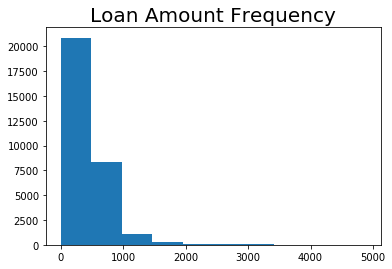

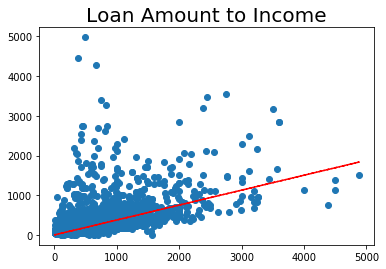

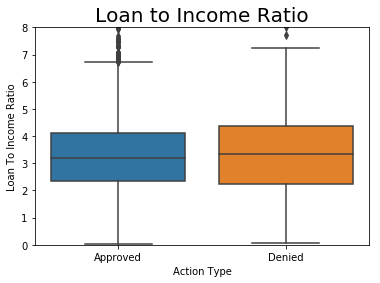

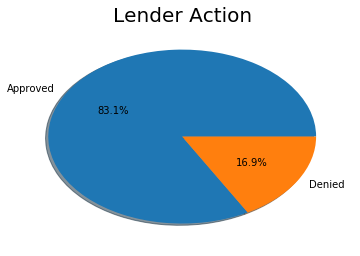

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#histogram
histData = df[df["Loan Amount (000s)"]<5000]["Loan Amount (000s)"]
histData = histData.dropna()
plt.hist(histData, bins=10)
plt.title("Loan Amount Frequency",fontsize=20)
plt.show()


#scatterplot
scatData = df[(df["Loan Amount (000s)"]<5000) & (df["Applicant Income (000s)"]<5000) & (df["Loan Purpose"]=="Home purchase")]
plt.scatter(scatData["Loan Amount (000s)"], scatData["Applicant Income (000s)"])
plt.title("Loan Amount to Income",fontsize=20)
z = np.polyfit(scatData["Loan Amount (000s)"], scatData["Applicant Income (000s)"], 1)
p = np.poly1d(z)
plt.plot(scatData["Loan Amount (000s)"],p(scatData["Loan Amount (000s)"]),"r--")
plt.show()


#box plot
boxplotData = df[(df["Loan To Income Ratio"]>0)&(df["Loan Purpose"]=="Home purchase")]
plt.title("Loan to Income Ratio",fontsize=20)
ax = sns.boxplot(x="Action Type",y="Loan To Income Ratio",data=boxplotData)
ax.set_ylim([0,8])
plt.show()

# pie chart
labels = ["Approved","Denied"]
approvals = df["Action Type"].value_counts()["Approved"]
denials = df["Action Type"].value_counts()["Denied"]
fracs = [approvals/(approvals+denials),denials/(approvals+denials)]

plt.pie(fracs, labels=labels, autopct='%1.1f%%', shadow=True)
plt.title("Lender Action",fontsize=20)
plt.show()

### Correlation Matrix

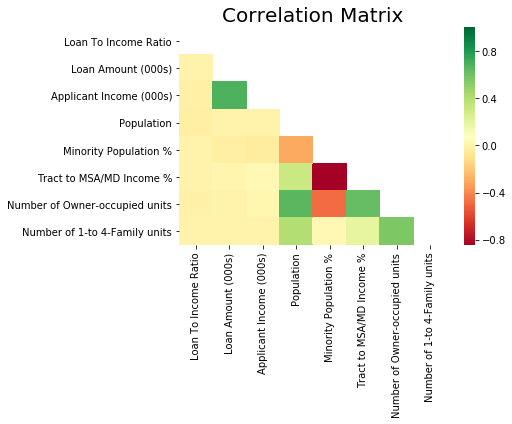

In [8]:
#https://seaborn.pydata.org/examples/many_pairwise_correlations.html

import numpy as np
import matplotlib.cm as cm

# create list of columns to view
colsToKeep = [
    #"Respondent ID",
    "Loan To Income Ratio",
    #"Agency Code",
    #"Loan Type",
    #"Property Type",
    #"Loan Purpose",
    #"Occupancy",
    "Loan Amount (000s)",
    #"Preapproval", #sparsely populated
    #"Action Type",
    #"Applicant Ethnicity",  #sparsely populated
    #"Co Applicant Ethnicity",  #sparsely populated
    #"Applicant Race 1",
    #"Co Applicant Race 1",
    #"Applicant Sex",
    #"Co Applicant Sex",
    "Applicant Income (000s)",
    #"Purchaser Type",  #appears to indicate whether or not the application was denied
    #"Rate Spread",  #sparsely populated
    #"HOEPA Status",
    #"Lien Status",
    "Population",
    "Minority Population %",
    #"FFIEC Median Family Income",
    "Tract to MSA/MD Income %",
    "Number of Owner-occupied units",
    "Number of 1-to 4-Family units"
    #,"Small Institution"
]

data = df[colsToKeep]

# create correlation matrix
corr = data.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# plot
plt.title("Correlation Matrix",fontsize=20)
sns.heatmap(corr, mask=mask,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            cmap="RdYlGn"
           )

### Census Tract Heatmaps

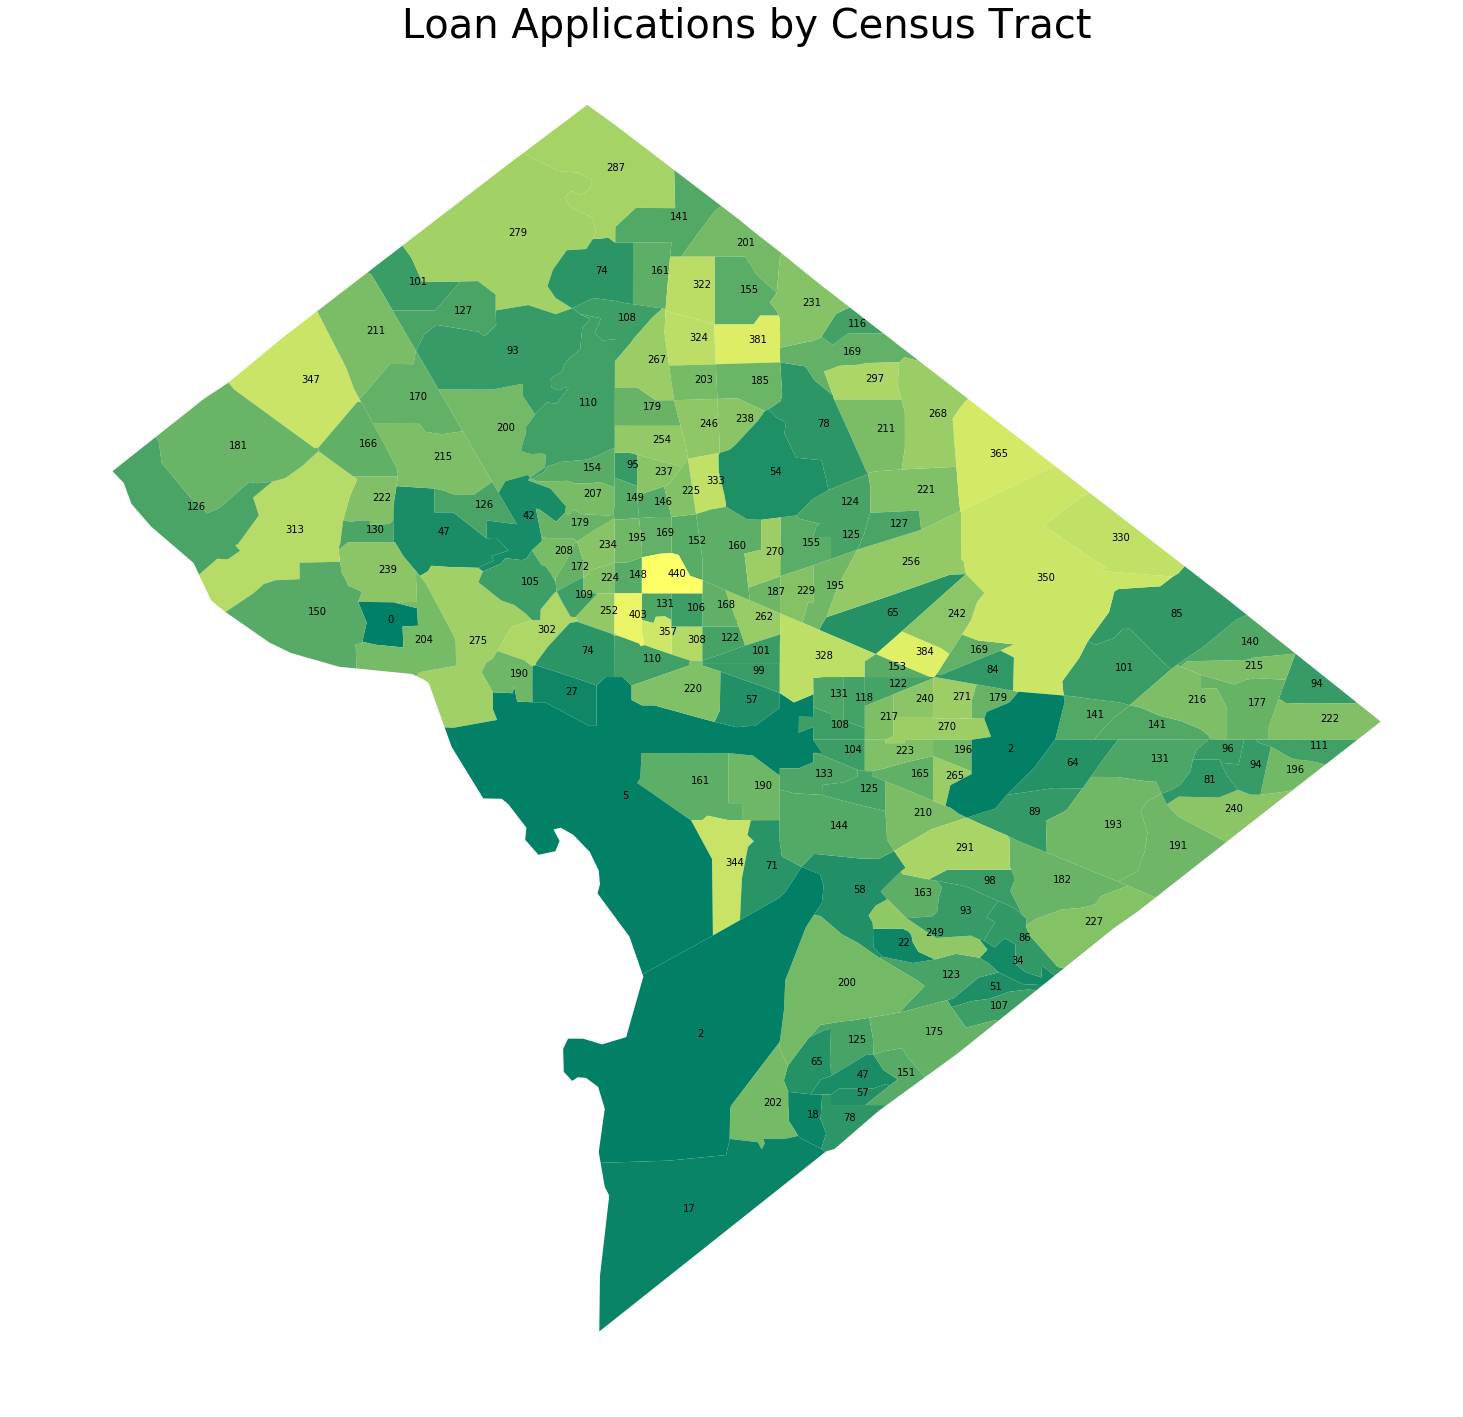

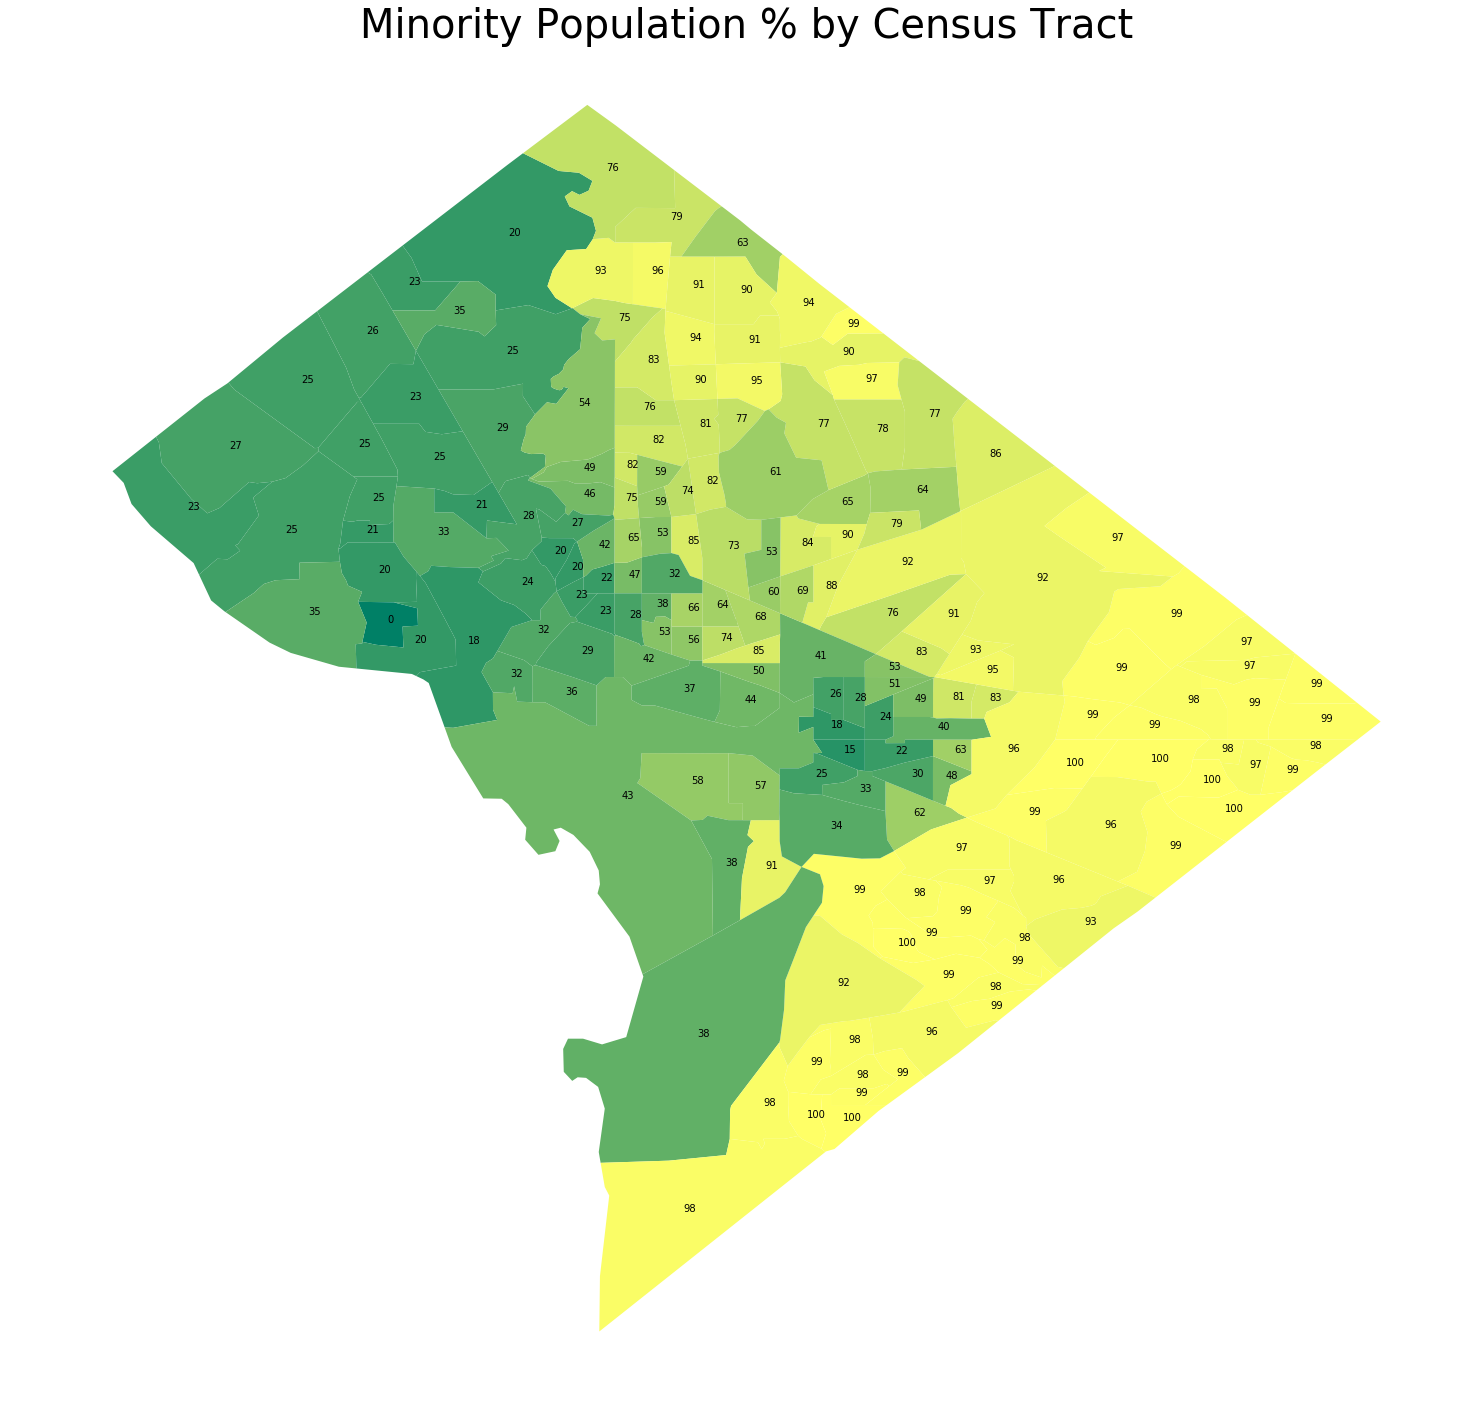

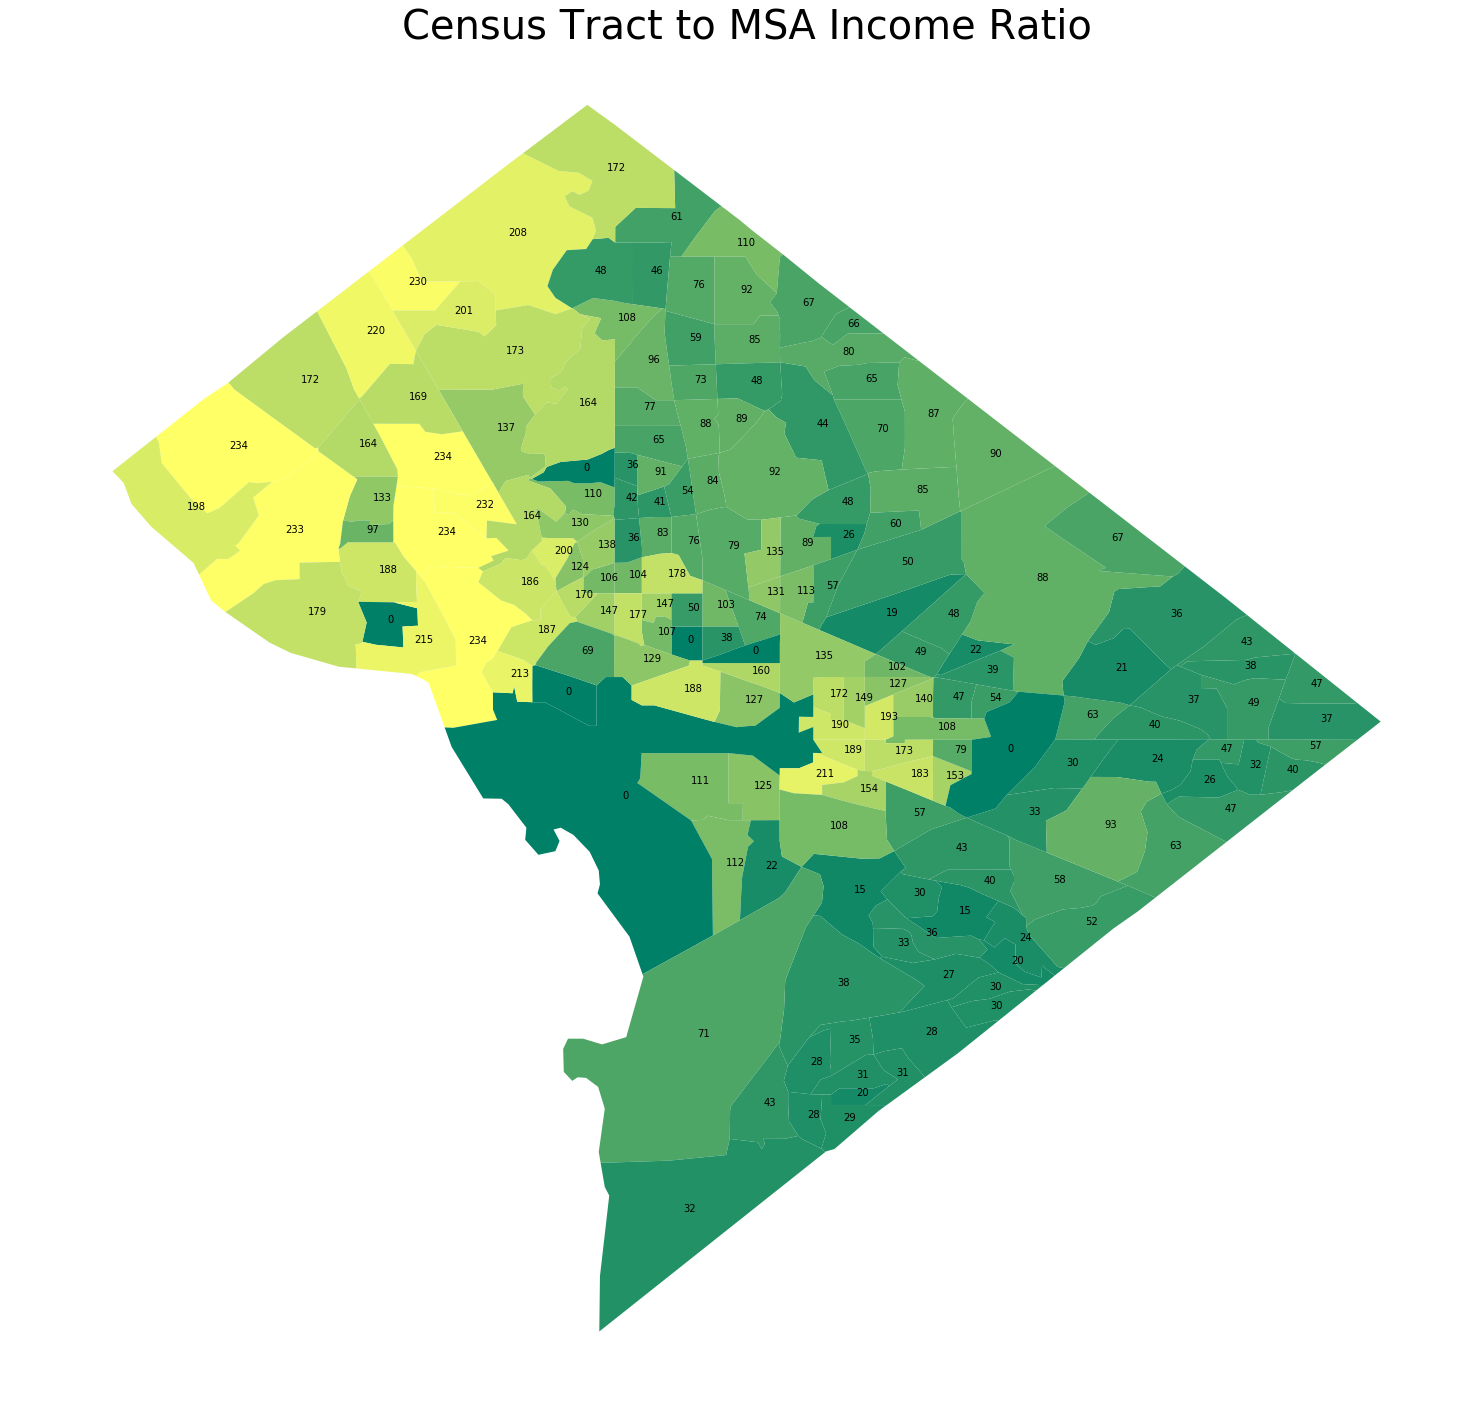

In [9]:
#https://chrishavlin.wordpress.com/2016/11/16/shapefiles-tutorial/
#https://pypi.org/project/pyshp/
#http://toblerity.org/shapely/manual.html#spatial-analysis-methods
#https://matplotlib.org/users/colormaps.html

def CensusTractHeatmap(df,title):
    import shapefile #PyShp
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    from shapely.geometry import Polygon
    from descartes.patch import PolygonPatch
  
    
    maxVal = int(df.iloc[:,2].max())

    shapes = shapefile.Reader("shapefiles/cb_2017_11_tract_500k")
    dcShapes = shapes.shapeRecords()
    allShapes = dcShapes

    fig = plt.figure(figsize=(25,25))
    ax = plt.axes() # add the axes
    ax.set_aspect('equal')
    plt.axis('off')

    shape_fields = [item[0] for item in shapes.fields[1:]]
    census_tract_idx = shape_fields.index('TRACTCE')
    state_idx = shape_fields.index('STATEFP')

    cmap = cm.summer(np.linspace(0.0, 1.0, maxVal+1))
    
    for shapeRec in list(allShapes):
        shape = shapeRec.shape
        rec = shapeRec.record
        state_code = float(rec[state_idx])
        census_tract = rec[census_tract_idx]

        vals = df[(df["State Code"] == state_code) & (df["CT Formatted"] == census_tract)].iloc[:,2]
        numLoans = int(vals.values[0]) if len(vals) > 0 else 0

        polygon = Polygon(shape.points)
        R = cmap[numLoans][0]
        G = cmap[numLoans][1]
        B = cmap[numLoans][2]

        patch = PolygonPatch(polygon, facecolor=[R,G,B], linewidth=0, edgecolor=[0,0,0], alpha=1.0, zorder=2)
        ax.add_patch(patch)

        centroid = polygon.centroid
        ct_label = str(numLoans)
        plt.text(centroid.x,centroid.y,ct_label,color='black')

    ax.relim()
    ax.autoscale_view()
    
    plt.title(title,fontsize=40)
    plt.show()
    return fig
    
# create a formatted version of census tract for mapping
df["CT Formatted"]=[('%07.2f' % x).replace(".","") for x in df["Census Tract Number"]]

count_by_CT = df.groupby(["State Code","CT Formatted"], as_index=False)["As of Year"].count()
fig = CensusTractHeatmap(count_by_CT,"Loan Applications by Census Tract")
fig.savefig('Census Tracts - Loan Applications.png')

count_by_CT = df.groupby(["State Code","CT Formatted"], as_index=False)["Minority Population %"].max()
fig = CensusTractHeatmap(count_by_CT,"Minority Population % by Census Tract")
fig.savefig('Census Tracts - Minority Pop %.png')

count_by_CT = df.groupby(["State Code","CT Formatted"], as_index=False)["Tract to MSA/MD Income %"].max()
fig = CensusTractHeatmap(count_by_CT,"Census Tract to MSA Income Ratio")
fig.savefig('Census Tracts - Tract to MSA Income Ratio.png')